# Polarization on Twitter
### By Jonathan Gustafsson Frennert

### I. Dependencies

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import seaborn as sns

import math
import numpy as np
np.random.seed(42)
from scipy.stats import mstats
import sklearn.metrics as skm
import pandas as pd
import dask.dataframe as dd
from igraph import Graph
import igraph as ig

import warnings
warnings.filterwarnings('ignore')

print("All packages imported!")

All packages imported!


### II. Matplotlib Parameters

In [2]:
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['font.size'] = 9

In [3]:
# Latex document Text width
latex_width = 390.0

def set_size(width=latex_width, height=latex_width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
    
    Credit to Jack Walton for the function.
    Source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    """

    fig_width_pt = width * fraction
    fig_height_pt = height * fraction
    
    inches_per_pt = 1 / 72.27
    
    fig_width_in = fig_width_pt * inches_per_pt
    fig_height_in = fig_height_pt * inches_per_pt * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

## III. Color Palette

The palette is from the [iWantHue](http://medialab.github.io/iwanthue/) website by Mathieu Jacomy at the Sciences-Po Medialab.

In [4]:
colors = [
    "#ba4c40",
    "#45c097",
    "#573485",
    "#a8ae3e",
    "#8874d9",
    "#69a050",
    "#be64b2",
    "#bc7d36",
    "#5d8ad4",
    "#b94973"
]

## IV. Twitter Dataset

**Provenance:** Ibrahim Sabuncu, "USA Nov.2020 Election 20 Mil. Tweets (with Sentiment and Party Name Labels) Dataset." *IEEE Dataport*, 14 Aug. 2020, doi: https://dx.doi.org/10.21227/25te-j338.

**License:** [Developer Agreement](https://developer.twitter.com/en/developer-terms/agreement)

**Usage Information:** 
- "you may only use the following information for non-commercial, internal purposes (e.g., to improve the functionality of the Services): (a) aggregate Twitter Applications user metrics, such as number of active users or accounts on Twitter Applications; (b) the responsiveness of Twitter Applications; and (c) results, usage statistics, data or other information (in the aggregate or otherwise) derived from analyzing, using, or regarding the performance of the Twitter API."

- "you may not use, or knowingly display, distribute, or otherwise make Twitter Content, or information derived from Twitter Content, available to any entity for the purpose of: (a) conducting or providing surveillance or gathering intelligence, including but not limited to investigating or tracking Twitter users or Twitter Content; (b) conducting or providing analysis or research for any unlawful or discriminatory purpose, or in a manner that would be inconsistent with Twitter users' reasonable expectations of privacy; (c) monitoring sensitive events (including but not limited to protests, rallies, or community organizing meetings); or (d) targeting, segmenting, or profiling individuals based on sensitive personal information, including their health (e.g., pregnancy), negative financial status or condition, political affiliation or beliefs, racial or ethnic origin, religious or philosophical affiliation or beliefs, sex life or sexual orientation, trade union membership, Twitter Content relating to any alleged or actual commission of a crime, or any other sensitive categories of personal information prohibited by law."

**Sentiment analysis tool:** Hutto, C.J. & Gilbert, E.E. (2014). "VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text." *Eighth International Conference on Weblogs and Social Media (ICWSM-14)*, June 2014. [GitHub](https://github.com/cjhutto/vaderSentiment)

<center> <h3>Dataset Contents*</h3> </center>

<center> <h4><code>uselection_tweets_1jul_11nov.csv</code></h4> </center>

| Variable | Format | Description | Example |
| :- | :- | :- | :- | 
| `Created-At`$\,$ | Timestamp$\,$ | Time at which tweet was created $\,$ | 7/1/20 7:44 PM |
| `From-User-Id`$\,$ | String$\,$ | Unique identifier of the user that sent the tweet $\,$ | 1223446325758394369 |
| `To-User-Id`$\,$ | String$\,$ | Unique identifier of the user that tweet sent to, -1 if nobody $\,$ | 387882597 |
| `Language`$\,$ | String$\,$ | ISO 639-1 language of the tweet $\,$ | en |
| `PartyName`$\,$ | String$\,$ | Which party is mentioned in the tweet $\,$ | BothParty |
| `Id`$\,$ | String$\,$ | Unique identifier of the tweet $\,$ | 1278368973948694528 |
| `Score`$\,$ | Float$\,$ | The sentiment score of the tweet $\,$ | 0.102564 |
| `Scoring String`$\,$ | String$\,$ | The sentiment score of the tweet $\,$ | 0.102564 |

\**only imported fields are shown.*

### Importing

In [5]:
twitter_cols = ['Created-At', 'From-User-Id', 'To-User-Id', 'Language', 'PartyName', 'Id', 'Score', 'Scoring String']
twitter_filepath = os.path.join(os.getcwd(), 'data', 'twitter', 'uselection_tweets_1jul_11nov.csv')

# twitter dask dataframe
tdd = dd.read_csv(twitter_filepath, sep=';', usecols=twitter_cols)

### Cleaning

- No duplicates found.

- Extreme values were found, but were kept.

#### Correcting Inferred Variable Types

In [6]:
tdd.dtypes

Created-At         object
From-User-Id        int64
To-User-Id          int64
Language           object
PartyName          object
Id                  int64
Score             float64
Scoring String     object
dtype: object

- `Created-At` should be a timestamp
- `From-User_Id` should be a string
- `To-User_Id` should be a string
- `Id` should be a string

In [7]:
tdd['Created-At'] = dd.to_datetime(tdd['Created-At'])
tdd['From-User-Id'] = tdd['From-User-Id'].astype('str')
tdd['To-User-Id'] = tdd['To-User-Id'].astype('str')
tdd['Id'] = tdd['Id'].astype('str')

#### Remove `NaN` Values

Some tweets were unscored and hence the `Scoring String` is `NaN`. These tweets were all removed.

In [8]:
tdd = tdd.dropna()

#### Initial Filters

- We filter for English to get more relevant tweets; the US speaks English. Further, the experiment done later involved English Speakers.

- We are primarily interested in tweets that can be fitted along the conservative-democrat political axis.

In [9]:
tdd = tdd[tdd['Language'] == 'en']
tdd = tdd[(tdd['PartyName'] == 'Republicans') | (tdd['PartyName'] == 'Democrats')]

#### Political Polarity

- We convert the categories into numerical values by sign.

In [10]:
polarity = {'Republicans': -1, 'Democrats' : 1}

tdd['PartyName'] = tdd['PartyName'].replace(polarity)

#### Drop Unused Columns

In [11]:
tdd = tdd.drop(columns=['Language', 'Scoring String'])

#### Rename and Reorder Columns

No particular reason, just prefer not using dictionary to access dataframe columns and a certain order of columns.

In [12]:
old_to_new = {
    'Created-At'   : 'time',
    'Id'           : 'id',
    'From-User-Id' : 'by',
    'To-User-Id'   : 'to',
    'PartyName'    : 'party',
    'Score'        : 'emotion'
}

order = ['time', 'id', 'by', 'to', 'party', 'emotion']

tdd = tdd.rename(columns=old_to_new)[order]

#### Compute Changes

Compute all cleaning at once and get a **Pandas** Dataframe.

In [13]:
tdf = tdd.compute()

## 1 Political Opinion

### 1.1 How well does `party` and `emotion` capture Political Opinion? 

To test the accuracy of the metrics, we will take a random sample of 1000 tweets and have I and a non-author assign the tweets to the four quadrants made up of party and emotion axis.

In [14]:
def quadrant(row):
    p = row.party
    e = row.emotion
    
    if (e > 0) and (p == 1):
        result = 1
    elif (e < 0) and (p == 1):
        result = 2
    elif (e < 0) and (p == -1):
        result = 3
    elif (e > 0) and (p == -1):
        result = 4
    else:
        result = 0
    
    return result

To convert quadrants to political opinion metric discussed in 1.2

In [15]:
def quadToOp(x):
    
    if x == 1:
        result = 1
    elif x == 2:
        result = -1
    elif x == 3:
        result = 1
    elif x == 4:
        result = -1
    else:
        result = 0
    
    return result

#### Creating sample

Retrieving 2000 ids as some tweets may be privated, deleted etc...

In [16]:
#file = 'sample.csv'
#tdf.id.sample(2000).to_csv(file, header = False, index = False)

#### Exporting Hydrated Sample

In [17]:
#sample_cols = ['id', 'text']
#sample_filepath = os.path.join(os.getcwd(), 'data', file)
#sdf = pd.read_csv(sample_filepath, usecols=sample_cols, dtype=str)

# prepare experiment
#sdf = sdf.dropna().head(1000)
#sdf = sdf.merge(right=tdf, how='left', on='id')
#sdf['label'] = sdf.apply(quadrant, axis=1)
#sdf = sdf[['id', 'text', 'label']]


#experiment_filepath = os.path.join(os.getcwd(), 'data', 'experiment.csv')
#sdf.to_csv(experiment_filepath, index=False)

A script was used for participants to input quadrants for tweets. I, the author, annotated 500 tweets (column `test2`) and a non-author annotated 140 tweets (column `test1`). 

#### Import Experiment Data

In [18]:
experiment_filepath = os.path.join(os.getcwd(), 'data', 'experiment.csv')
edf = pd.read_csv(experiment_filepath).head(500)

#### Measuring Agreement

Firstly, we measure the agreement between the participants on labelling. We evaluate this with the 140 tweets that both participants labelled. The metric commonly applied in this situation is Cohen's Kappa,

$\kappa = \dfrac{p_o - p_e}{1 - p_e}$

where $p_o$ is the observed agreement ratio between the annotators and $p_e$ is the expected agreement when both annotators are randomly assigning labels given each annotators relative frequency of class labels.

**Metric:** J. Cohen (1960). “A coefficient of agreement for nominal scales”. *Educational and Psychological Measurement 20(1):37-46*. doi:10.1177/001316446002000104.

In [19]:
bdf = edf.iloc[0:140]
kl = skm.cohen_kappa_score(bdf.test1, bdf.test2)
ko = skm.cohen_kappa_score(bdf.test1Op, bdf.test2Op)

print(f'Label k: {kl}')
print(f'Opinion k: {ko}')

Label k: 0.7652582159624413
Opinion k: 0.7434957860021987


$\kappa$ between 0.6-0.8 is considered substantial agreement. This would support that the labels assigned by participants capture a similar notion of the political content in the tweets. This suggests that the participants labelling can be used to measure the accuracy of the sentiment analysis and party tagging in capturing the political content of the tweets. 

**Source:** Viera AJ, Garrett JM. Understanding interobserver agreement: the kappa statistic. *Fam Med*. 2005 May;37(5):360-3. PMID: 15883903.

In [20]:
t1_acc = len(bdf[bdf.test1 == bdf.label]) / 140
t1Op_acc = len(bdf[bdf.test1Op == bdf.labelOp]) / 140

t2_acc = len(edf[edf.label == edf.test2]) / 500 
t2Op_acc = len(edf[edf.labelOp == edf.test2Op]) / 500 

print(f'Participant 1 label accuracy: {t1_acc}')
print(f'Participant 2 label accuracy: {t2_acc}\n')
print(f'Participant 1 opinion accuracy: {t1Op_acc}')
print(f'Participant 2 opinion accuracy: {t2Op_acc}\n')

Participant 1 label accuracy: 0.5071428571428571
Participant 2 label accuracy: 0.536

Participant 1 opinion accuracy: 0.5357142857142857
Participant 2 opinion accuracy: 0.574



In [21]:
bldf = bdf[bdf.test1 == bdf.test2]
print(skm.classification_report(bldf.test1, bldf.label))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.74      0.82      0.78        17
           2       0.56      0.42      0.48        12
           3       0.84      0.56      0.67        75
           4       0.12      0.62      0.20         8

    accuracy                           0.55       120
   macro avg       0.45      0.49      0.43       120
weighted avg       0.69      0.55      0.59       120



In [22]:
bodf = bdf[bdf.test1Op == bdf.test2Op]
print(skm.classification_report(bodf.test1Op, bodf.labelOp))

              precision    recall  f1-score   support

          -1       0.22      0.60      0.32        20
           0       0.00      0.00      0.00         8
           1       0.83      0.61      0.70        97

    accuracy                           0.57       125
   macro avg       0.35      0.40      0.34       125
weighted avg       0.68      0.57      0.60       125



### 1.2 Political Opinion Metric

The political opinion of a tweet is the *point along the conservative-democrat political axis $[-1,1]$ that the content in the tweet expresses*. We want to convert tweets to these values as it lets us quantitively study political polarization over the time period the tweets were collected. 

#### `party` x Linearly Scaled `emotion`

We will be scaling the `emotion` to $[-1,1]$ using minimum and maximum `emotion` values, however we do not want the outliers to have a disproportionate effect. To fix this, we will winzorise the emotion scores. Intuitively, it is unlikely that outliers are expressing particularly more emotions than the 0.01 percentile or more than the 99.99 percentile (~2500 tweets). These tweets are largely result from people repeating a certain connotated word (e.g., love or loser) that is picked up by the sentiment analysis tool leading to extreme values.

In [23]:
xs = mstats.winsorize(tdf.emotion, limits=[0.0001, 0.0001]) 

# maximum magnitude of emotion
scale = max(-xs.min(), xs.max())

# political opinion metric
tdf['opinion'] = (tdf.party * xs / scale).values

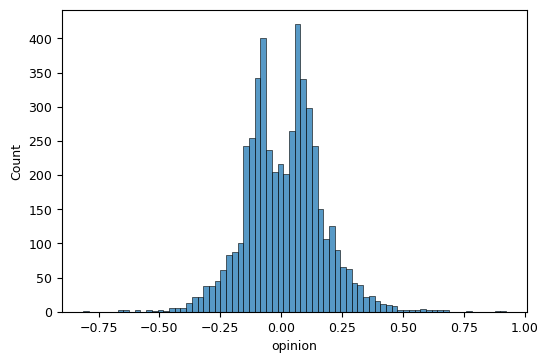

In [24]:
sns.histplot(tdf.opinion.sample(5000))
plt.show()

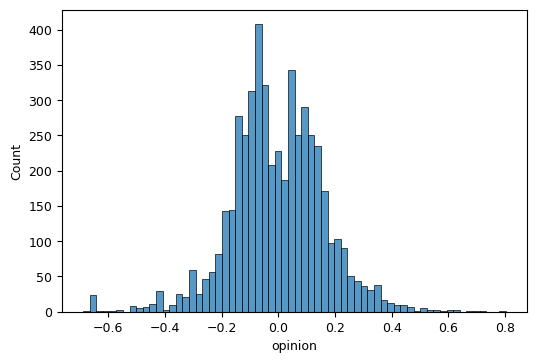

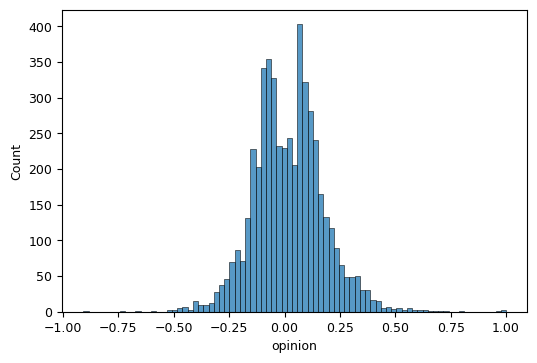

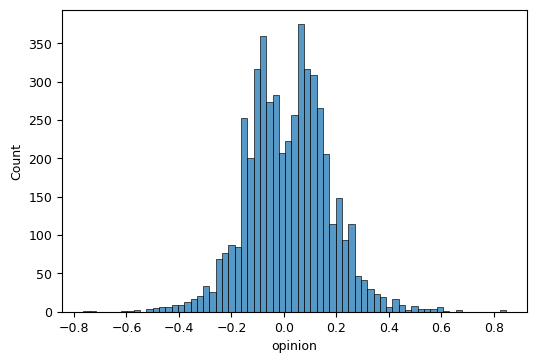

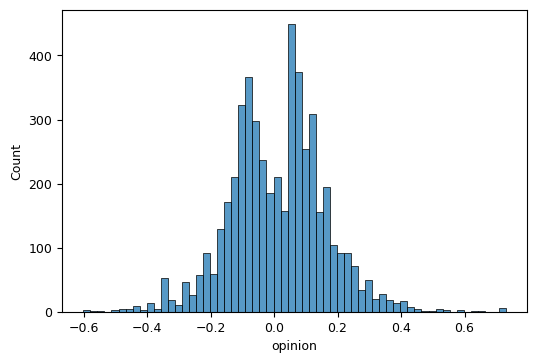

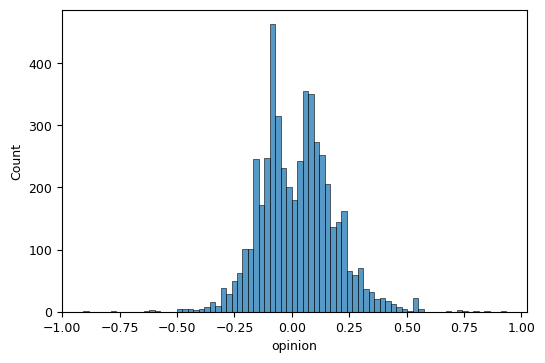

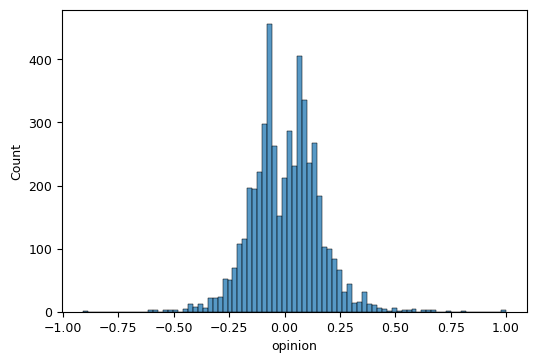

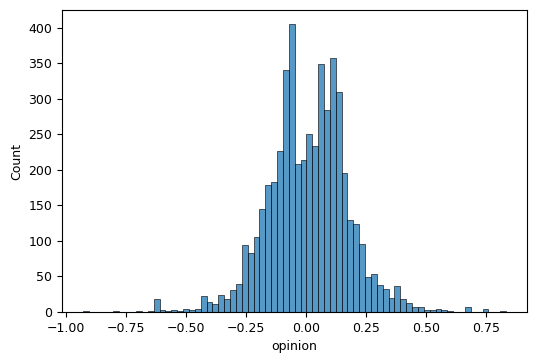

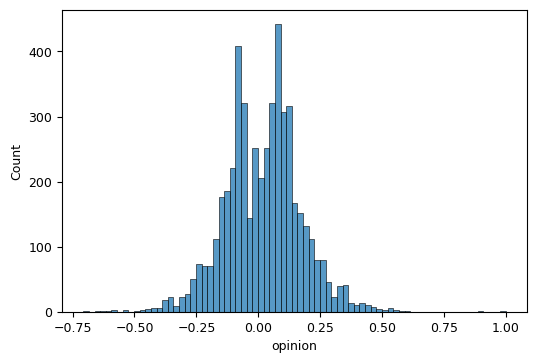

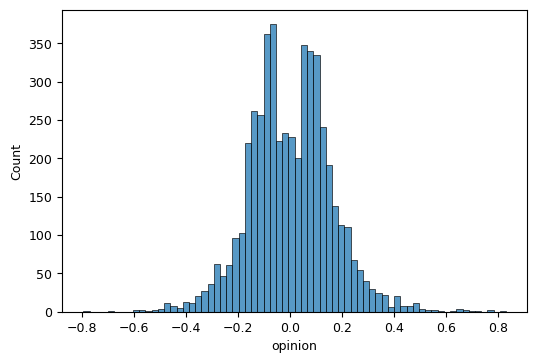

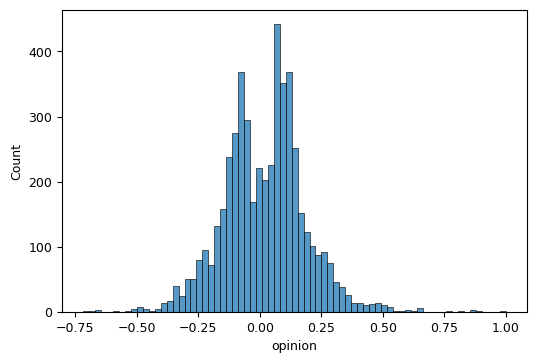

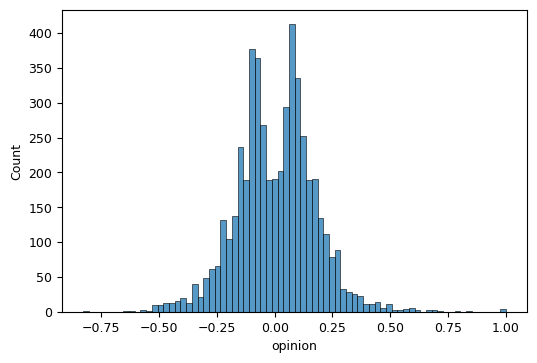

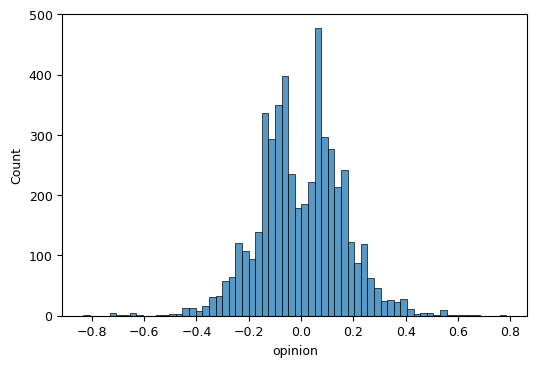

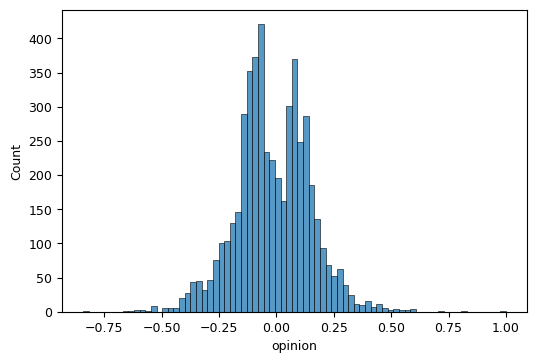

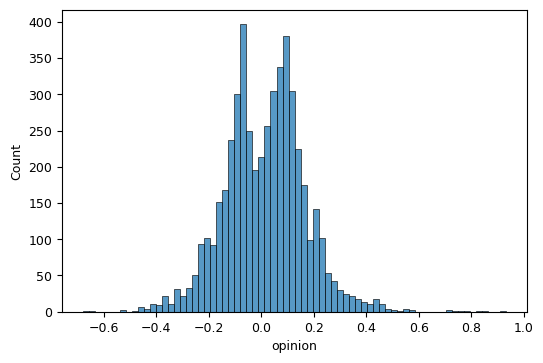

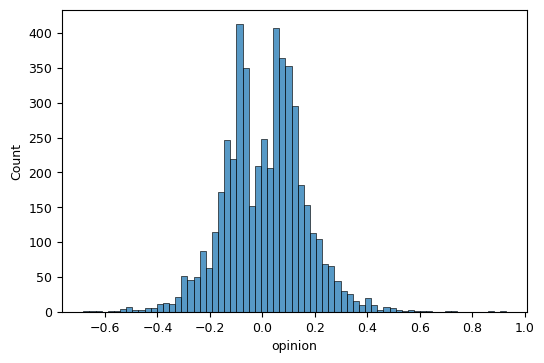

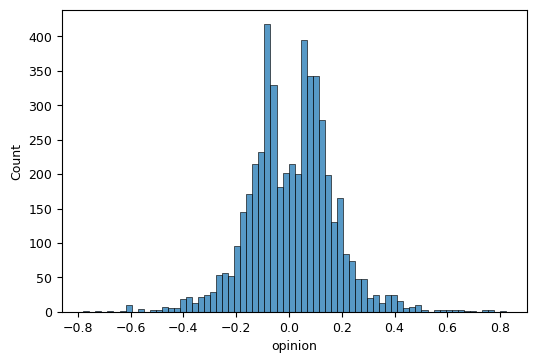

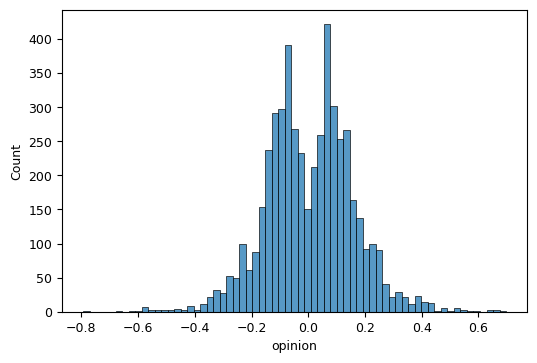

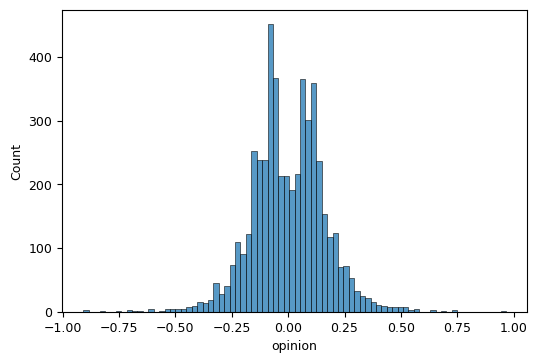

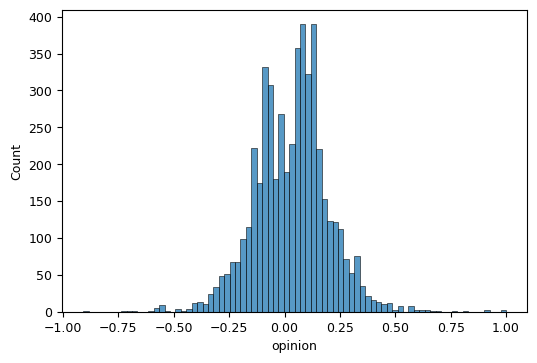

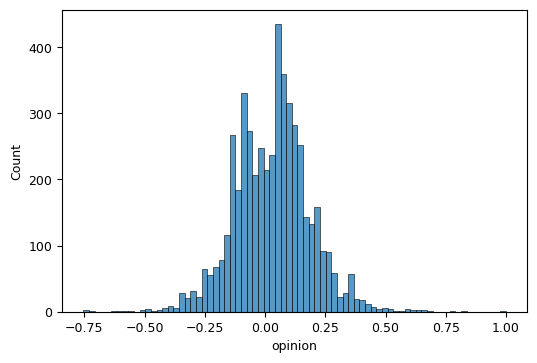

In [25]:
for name, group in tdf.groupby(tdf.time.dt.week):
    sns.histplot(group.opinion.sample(5000))
    plt.show()

The distribution of political opinions shows a clear sign of polarization in the tweets. From 1.1, we see that this metric can moderately capture the political content of a tweet, and therefore, we will continue to use this dataset for our study of polarization. The next step is to create the network from the users.

## 2 Political Influence

### 2.1 Largest Strongly Connected Component

We will study opinions expressed in the largest strongly connected component as this forms a user network that characterises the majority of the behaviour happening in the twitter feed. The network includes 108737 users, the second largest cluster includes 14 users.

In [26]:
cdf = tdf[tdf.to != '-1'][['by','to']]
cg = Graph.DataFrame(cdf, directed=True)

cs = cg.components()
lcg = cs.giant()
lc_ids = lcg.vs['name']
lcdf = tdf[tdf.by.isin(lc_ids) & (tdf.to.isin(lc_ids) | (tdf.to == '-1'))][['time','by', 'to', 'opinion']]

### 2.2 Influence of Received Opinions on Sent Opinions 

In [27]:
INTR_COLS = ['time', 'opinion']

def interaction(user, df):
    by = df[df.by == user][INTR_COLS] 
    to = df[df.to == user][INTR_COLS] 

    result = []
    for _, msg in by.iterrows():
        result.append((msg, to[to.time < msg.time]))
    
    return result

In [28]:
def interaction_analysis(df, sample_total):
    users = np.random.choice(df.by.unique(), size=sample_total)
    intrs = [interaction(user, df) for user in users]
    
    result = []
    for i in range(len(users)):
        by_ops = [] 
        to_ops = []
        for by, to in intrs[i]:
            by_ops.append(by.opinion)
            to_ops.append(to.opinion.mean())
        result.append((users[i], by_ops, to_ops)) 

    return result

In [29]:
intra = interaction_analysis(lcdf, 1000)
coefs = []
for user, by_ops, to_ops in intra:
    by_ops_valid = [] 
    to_ops_valid = []
    for i in range(len(by_ops)):
        if not math.isnan(to_ops[i]):
            by_ops_valid.append(by_ops[i])
            to_ops_valid.append(to_ops[i])
    if len(by_ops_valid) > 2:
        corr = np.corrcoef(by_ops_valid, to_ops_valid)[0,1]    
        if not math.isnan(corr):
            coefs.append((user, corr))

<AxesSubplot:ylabel='Count'>

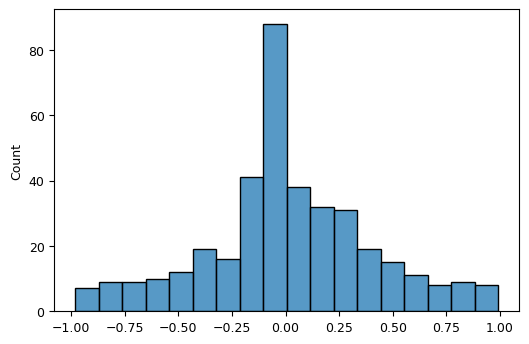

In [30]:
sns.histplot(list(map(lambda x: x[1], coefs)))

In [31]:
init_corr_ops = list(map(lambda x: (lcdf[lcdf.by == x[0]].opinion.values[0], x[1]), coefs))
x = list(map(lambda x: abs(x[0]), init_corr_ops))
y = list(map(lambda x: x[1],init_corr_ops))

<AxesSubplot:>

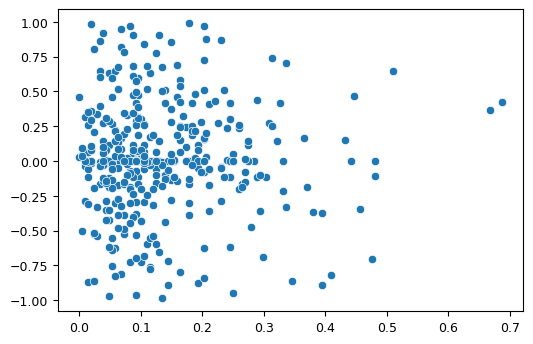

In [32]:
sns.scatterplot(x=x, y=y)

#### 2.3 Largest Cluster in Outspoken Users

In [33]:
weeks_total = (tdf.time.max() - tdf.time.min()).days / 7

In [34]:
odf = tdf.groupby('by').filter(lambda x: len(x) > weeks_total)

In [35]:
ocdf = odf[odf.to != '-1'][['by', 'to']]
ocg = Graph.DataFrame(ocdf, directed=True)

ocs = ocg.components()
olcg = ocs.giant()
olc_ids = olcg.vs['name']
olcdf = tdf[tdf.by.isin(lc_ids) & (tdf.to.isin(lc_ids) | (tdf.to == '-1'))][['time','by', 'to', 'opinion']]

#### 2.4 Influence of Recieved Opinion on Sent Opinion with Outspoken Users

In [37]:
intra = interaction_analysis(olcdf, 1000)
coefs = []
for user, by_ops, to_ops in intra:
    by_ops_valid = [] 
    to_ops_valid = []
    for i in range(len(by_ops)):
        if not math.isnan(to_ops[i]):
            by_ops_valid.append(by_ops[i])
            to_ops_valid.append(to_ops[i])
    if len(by_ops_valid) > 2:
        corr = np.corrcoef(by_ops_valid, to_ops_valid)[0,1]    
        if not math.isnan(corr):
            coefs.append((user, corr))

<AxesSubplot:ylabel='Count'>

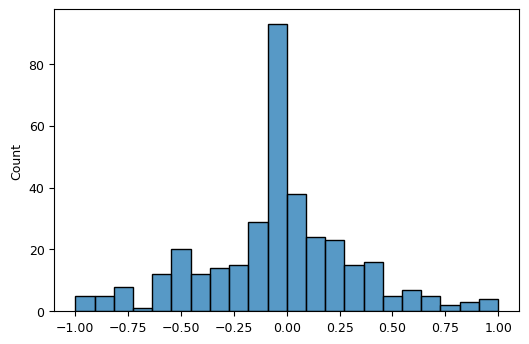

In [38]:
sns.histplot(list(map(lambda x: x[1], coefs)))

In [39]:
init_corr_ops = list(map(lambda x: (olcdf[olcdf.by == x[0]].opinion.values[0], x[1]), coefs))
x = list(map(lambda x: abs(x[0]), init_corr_ops))
y = list(map(lambda x: x[1],init_corr_ops))

<AxesSubplot:>

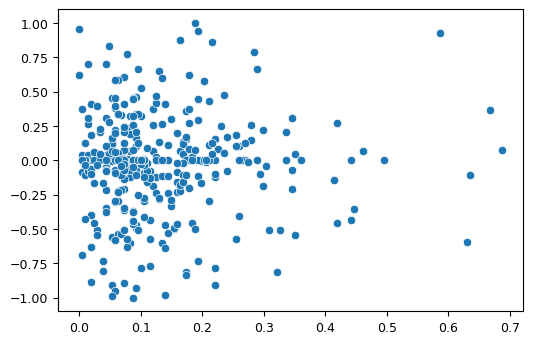

In [40]:
sns.scatterplot(x=x, y=y)

### 2.5 Moving Towards or Away from Sent Opinions in Outspoken Cluster

In [41]:
def interaction_mean(user, df):
    by = df[df.by == user][INTR_COLS] 
    to = df[df.to == user][INTR_COLS] 

    result = []
    for _, msg in by.iterrows():
        byop = msg.opinion
        toop = to[(msg.time - pd.Timedelta(days=7) <= to.time) & (to.time < msg.time)].opinion.mean()
        if not math.isnan(toop):
            result.append((byop, toop))
    
    return result

In [42]:
def direction_analysis(df, sample_total):
    users = np.random.choice(df.by.unique(), size=sample_total)
    valid_users = []
    intrs = []    
    for user in users:
        intr = interaction_mean(user, df) 
        # We need at least two opinion changes to see difference
        if len(intr) > 1:
            valid_users.append(user)
            intrs.append(intr)
    
    result = []
    for i in range(len(valid_users)):
        dirs = []
        for j in range(1,len(intrs[i])):
            if abs(intrs[i][j][1] - intrs[i][j][0]) < abs(intrs[i][j][1] - intrs[i][j-1][0]):
                dirs.append(1)
            elif abs(intrs[i][j][1] - intrs[i][j][0]) > abs(intrs[i][j][1] - intrs[i][j-1][0]):
                dirs.append(-1)
            else:
                dirs.append(0)
            
        result.append((valid_users[i], dirs)) 

    return result

In [43]:
dirsa = direction_analysis(olcdf, 1000)

In [44]:
initial = list(map(lambda x: olcdf[olcdf.by == x[0]].opinion.values[0], dirsa))
overall = list(map(lambda x: np.sum(x[1]), dirsa))

<AxesSubplot:ylabel='Count'>

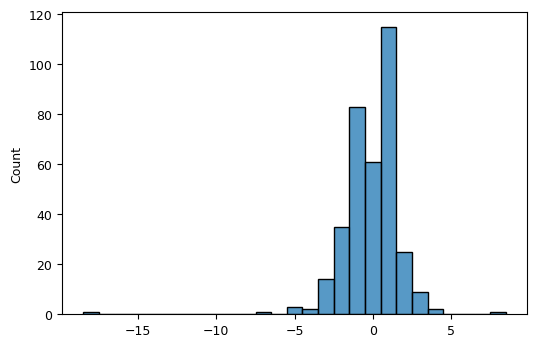

In [45]:
sns.histplot(overall, discrete=True)

<AxesSubplot:>

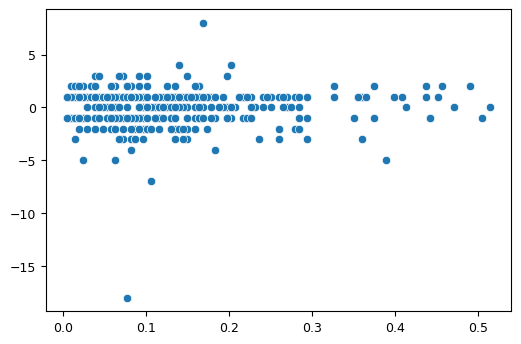

In [50]:
sns.scatterplot(map(abs, initial), overall)

In [51]:
towards = []
away = []
for user, dirs in dirsa:
    towards.append(dirs.count(1))
    away.append(dirs.count(-1))

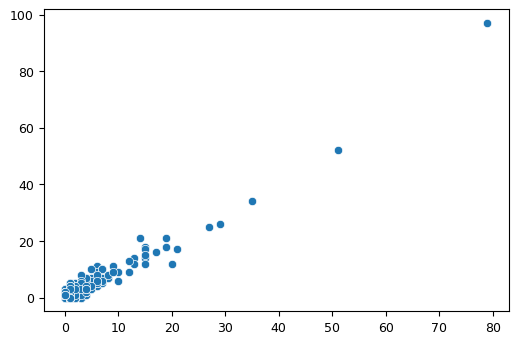

In [53]:
sns.scatterplot(towards,away)
plt.show()

### 2.6 Polarity of User and Polarity of Tweets received

In [66]:
def interaction_polarity(user, df):
    by = df[df.by == user].opinion.mean()
    to = df[df.to == user].opinion 
    
    return list(map(lambda x: np.sign(by * x), to))

In [73]:
def polarity_analysis(df, sample_total):
    users = np.random.choice(df.by.unique(), size=sample_total)
    result = [(df[df.by == user].opinion.values[0], interaction_polarity(user, df)) for user in users]
    return result

In [75]:
polsa = polarity_analysis(olcdf, 1000)

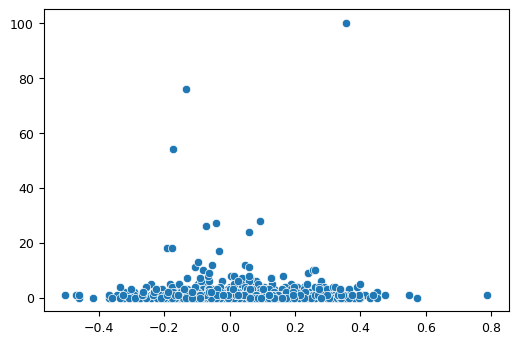

In [76]:
sns.scatterplot(map(lambda x: x[0], polsa),map(lambda x: x[1].count(-1), polsa))
plt.show()

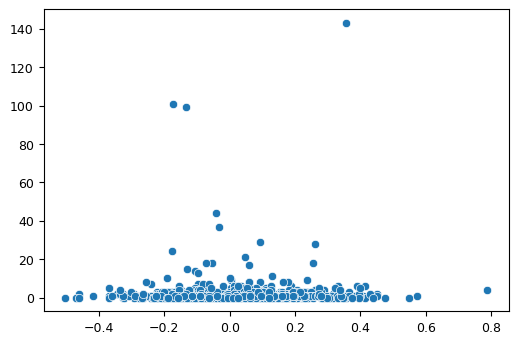

In [77]:
sns.scatterplot(map(lambda x: x[0], polsa),map(lambda x: x[1].count(1), polsa))
plt.show()